# Import Library and file path



In [ ]:
data_file_path = 'CSE440_data.csv' #defualt data file path if in the same directory
glove_300dtxt_path = '/content/drive/MyDrive/CSE440/glove.6B.300d.txt' # change the file path based on the glove embedding destination path
# set glove path "glove.6B.300d.txt" if in the same directory

In [ ]:
!pip install numpy pandas scikit-learn tensorflow keras nltk matplotlib seaborn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from collections import Counter

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Import Data

In [ ]:
try:
    df = pd.read_csv(data_file_path)
except:
    from google.colab import drive
    drive.mount('/content/drive')
    df = pd.read_csv('/content/drive/MyDrive/CSE440/CSE440_data.csv')
df

Mounted at /content/drive


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


#Data Visualization

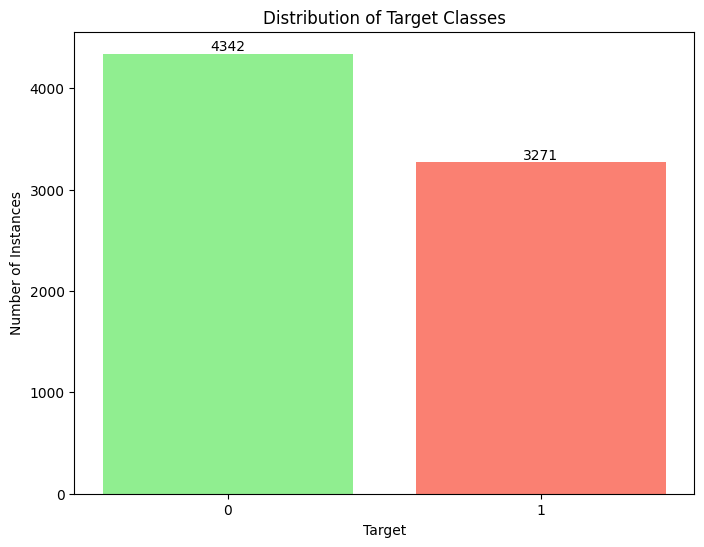

In [ ]:
target_counts = df['target'].value_counts()

plt.figure(figsize=(8, 6))
bars = plt.bar(target_counts.index, target_counts.values, color=['lightgreen', 'salmon'])
plt.xlabel('Target')
plt.ylabel('Number of Instances')
plt.title('Distribution of Target Classes')
plt.xticks([0, 1], ['0', '1'])

for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, yval, yval, ha='center', va='bottom')


plt.show()


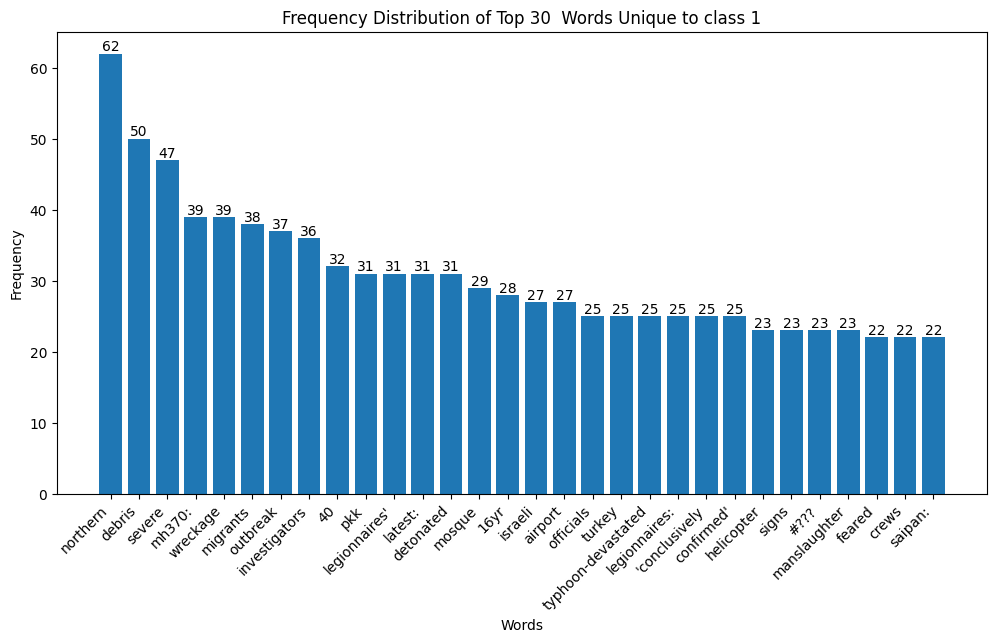

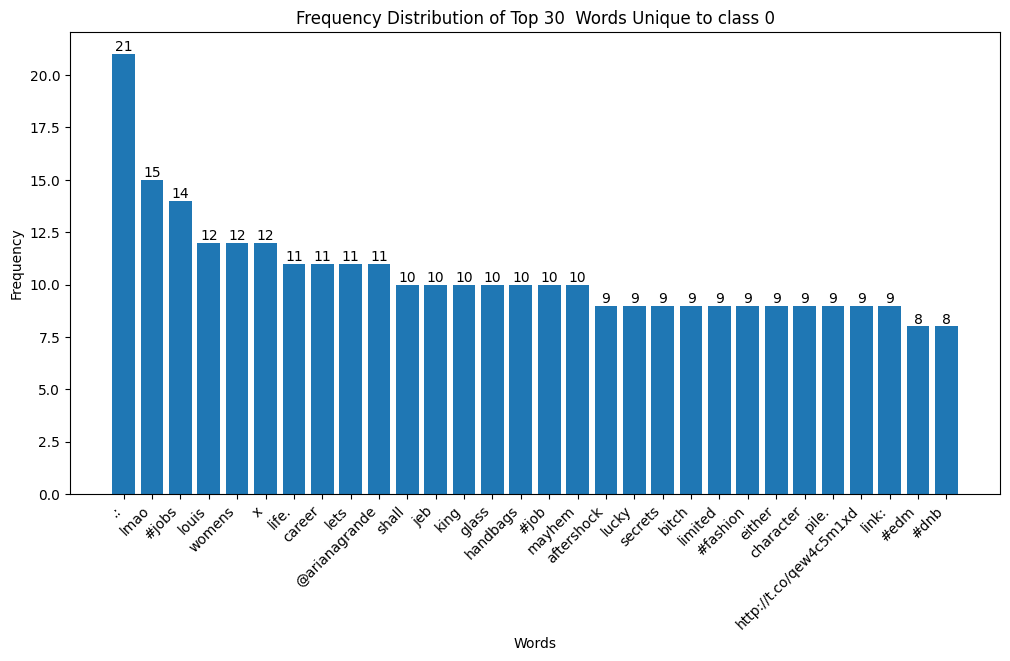

In [ ]:
disaster_tweets = df[df['target'] == 1]['text']

all_words_disaster = []
for tweet in disaster_tweets:
  words = tweet.lower().split()
  all_words_disaster.extend(words)

word_counts_disaster = Counter(all_words_disaster)

not_disaster_tweets = df[df['target'] == 0]['text']

all_words_not_disaster = []
for tweet in not_disaster_tweets:
  words = tweet.lower().split()
  all_words_not_disaster.extend(words)

word_counts_not_disaster = Counter(all_words_not_disaster)

unique_disaster_words = {word: count for word, count in word_counts_disaster.items() if word not in word_counts_not_disaster}
unique_not_disaster_words = {word: count for word, count in word_counts_not_disaster.items() if word not in word_counts_disaster}


top_30_unique_disaster_words = dict(sorted(unique_disaster_words.items(), key=lambda item: item[1], reverse=True)[:30])
top_30_unique_not_disaster_words = dict(sorted(unique_not_disaster_words.items(), key=lambda item: item[1], reverse=True)[:30])

plt.figure(figsize=(12, 6))
plt.bar(top_30_unique_disaster_words.keys(), top_30_unique_disaster_words.values())
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Frequency Distribution of Top 30  Words Unique to class 1")
plt.xticks(rotation=45, ha='right')

for i, (word, count) in enumerate(top_30_unique_disaster_words.items()):
  plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()


plt.figure(figsize=(12, 6))
plt.bar(top_30_unique_not_disaster_words.keys(), top_30_unique_not_disaster_words.values())
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Frequency Distribution of Top 30  Words Unique to class 0")
plt.xticks(rotation=45, ha='right')

for i, (word, count) in enumerate(top_30_unique_not_disaster_words.items()):
  plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

# Data split 0.9 ratio

In [ ]:
df = df.drop(['id', 'keyword', 'location'], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

X = df['text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42) #randomly selecting data points to split with seed/pattern selected as 42


# Data Sanitization

In [ ]:
import re

def sanitize_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'(.)\1{2,}', r'\1', text)  # Remove characters repeated more than twice
    text = re.sub(r'\s+', ' ', text).strip()  # Replace multiple spaces with a single space
    return text

X_train = X_train.apply(sanitize_text)
X_test = X_test.apply(sanitize_text)
X_train

,text
4620,'mcfadden reportedly to test hamstring thursda...
2858,w--=-=-=-[ nema warns nigerians to prepare for...
3098,when i was cooking earlier i got electrocuted ...
3751,i'm on fire.
5285,more than families affected by the fatal outbr...
...,...
5226,@eganator there aren't many obliteration serve...
5390,just had a panic attack bc i don't have enough...
860,omron hem-c automatic blood pressure monitor s...
7603,officials say a quarantine is in place at an a...


In [ ]:
from collections import Counter

word_counts = Counter()
for text in X_train:
  for word in text.split():
    word_counts[word] += 1

unique_words_freq_more_than_1 = sum(1 for count in word_counts.values() if count > 1)
print("Number of unique words with frequency more than 1:", unique_words_freq_more_than_1)

Number of unique words with frequency more than 1: 6788


# Tokenization

In [ ]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq)

max_length_X_train_pad = len(X_train_pad[0])
for i in range(1, len(X_train_pad)):
  if len(X_train_pad[i]) > max_length_X_train_pad:
    max_length_X_train_pad = len(X_train_pad[i])

print("Max length of X_train_pad:", max_length_X_train_pad)
max_length = max_length_X_train_pad

X_test_pad = pad_sequences(X_test_seq, max_length)

Max length of X_train_pad: 31


# Word embedding

In [ ]:
import numpy as np

embeddings_index = {}
with open(glove_300dtxt_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

vocab_size = 10000
embedding_dim = 300

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


# Model Evalutation function

In [ ]:
def f1_score(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)

    f1 = 2 * ((precision_value * recall_value) / (precision_value + recall_value + K.epsilon()))
    return f1

# Model Implementation

In [ ]:

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(128, dropout=0.1, recurrent_dropout=0.1, return_sequences=False)))
model.add(Dense(1, activation='sigmoid'))
model.build(input_shape=(None, max_length))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score])


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 31, 300)             │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256)                 │         439,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,439,553 (13.12 MB)

 Trainable params: 439,553 (1.68 MB)

 Non-trainable params: 3,000,000 (11.44 MB)

In [ ]:

model_gru = Sequential()
model_gru.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False))
model_gru.add(Bidirectional(keras.layers.GRU(128, dropout=0.1, recurrent_dropout=0.1, return_sequences=True)))
model_gru.add(Bidirectional(keras.layers.GRU(64, dropout=0.1, recurrent_dropout=0.1, return_sequences=False)))
model_gru.add(Dense(1, activation='sigmoid'))
model_gru.build(input_shape=(None, max_length))

model_gru.summary()

model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score])


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 31, 300)             │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 31, 256)             │         330,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 128)                 │         123,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,454,017 (13.18 MB)

 Trainable params: 454,017 (1.73 MB)

 Non-trainable params: 3,000,000 (11.44 MB)

In [ ]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
np.random.seed(42)
history = model.fit(X_train_pad, y_train, batch_size=64, epochs=num_epochs, validation_split=0.1,callbacks = [early_stop])
history_gru = model_gru.fit(X_train_pad, y_train, batch_size=64, epochs=num_epochs, validation_split=0.1, callbacks=[early_stop])

Epoch 1/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 24s 184ms/step - accuracy: 0.7395 - f1_score: 0.6627 - loss: 0.5339 - val_accuracy: 0.7857 - val_f1_score: 0.7569 - val_loss: 0.4631
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.8054 - f1_score: 0.7395 - loss: 0.4198 - val_accuracy: 0.7915 - val_f1_score: 0.7232 - val_loss: 0.4670
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 183ms/step - accuracy: 0.8231 - f1_score: 0.7741 - loss: 0.3982 - val_accuracy: 0.8149 - val_f1_score: 0.7702 - val_loss: 0.4390
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - accuracy: 0.8385 - f1_score: 0.8000 - loss: 0.3699 - val_accuracy: 0.8076 - val_f1_score: 0.7561 - val_loss: 0.4437
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 18s 182ms/step - accuracy: 0.8482 - f1_score: 0.8070 - loss: 0.3487 - val_accuracy: 0.7974 - val_f1_score: 0.7591 - val_loss: 0.4399
Epoch 1/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 315ms/step - accuracy: 0.7323 - f1_score: 0.6683 - loss: 0.5373 - val_accuracy: 0.7872 - val_f1_score: 

# Model Evaluation

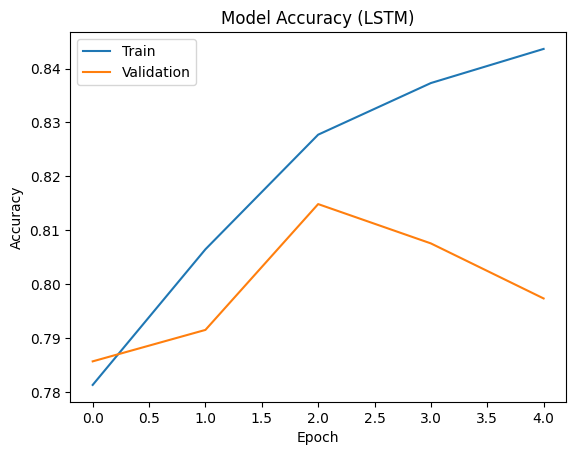

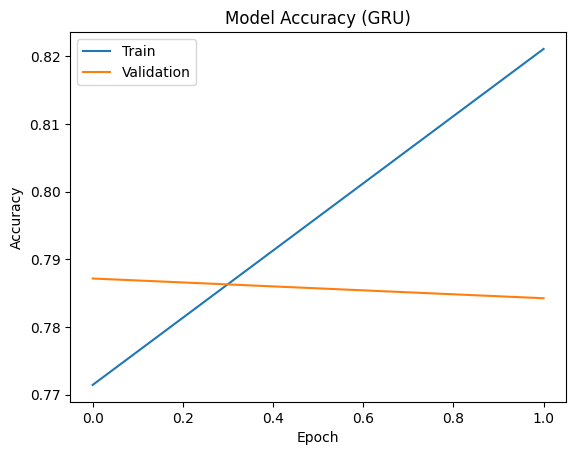

In [ ]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy (LSTM)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


plt.plot(history_gru.history['accuracy'])
plt.plot(history_gru.history['val_accuracy'])
plt.title('Model Accuracy (GRU)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")
loss, accuracy, f1 = model.evaluate(X_test_pad, y_test, verbose=0)
print("BiLSTM Model:")
print("Loss:", loss)
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step
BiLSTM Model:
Loss: 0.45491576194763184
Accuracy: 0.7939632534980774
F1 Score: 0.7620988488197327
Accuracy:  0.7939632545931758
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       426
           1       0.76      0.77      0.77       336

    accuracy                           0.79       762
   macro avg       0.79      0.79      0.79       762
weighted avg       0.79      0.79      0.79       762



In [ ]:
y_pred = (model_gru.predict(X_test_pad) > 0.5).astype("int32")
loss_gru, accuracy_gru, f1_gru = model_gru.evaluate(X_test_pad, y_test, verbose=0)
print("GRU Model:")
print("Loss:", loss_gru)
print("Accuracy:", accuracy_gru)
print("F1 Score:", f1_gru)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step
GRU Model:
Loss: 0.4659058153629303
Accuracy: 0.7913385629653931
F1 Score: 0.7664287686347961
Accuracy:  0.7913385826771654
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       426
           1       0.75      0.79      0.77       336

    accuracy                           0.79       762
   macro avg       0.79      0.79      0.79       762
weighted avg       0.79      0.79      0.79       762



24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


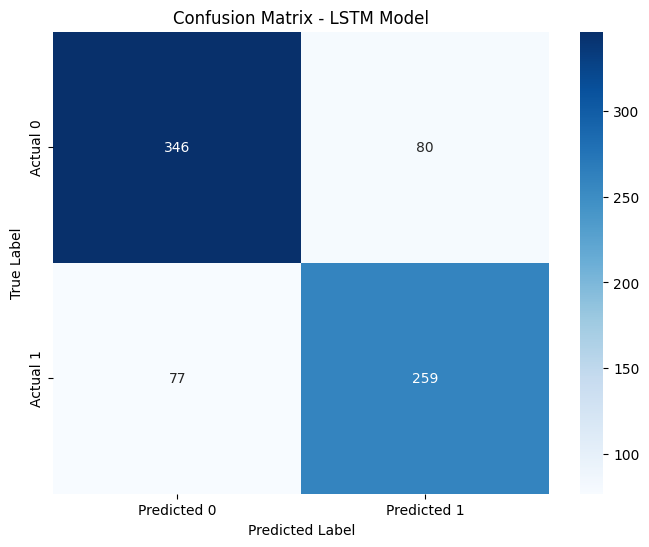

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step


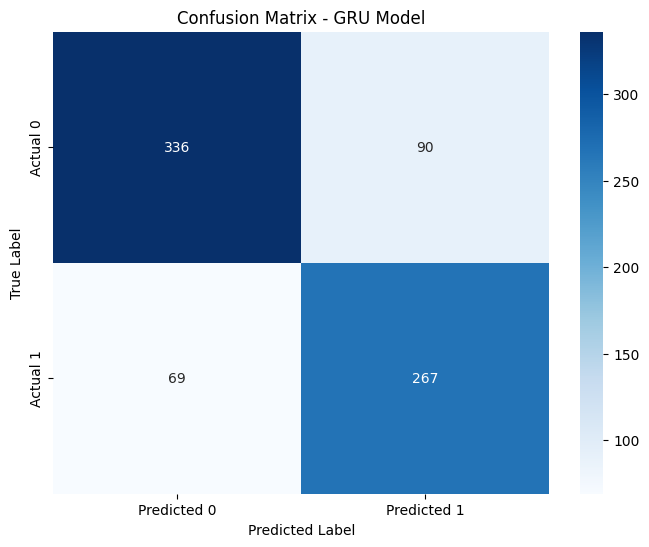

In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_lstm = (model.predict(X_test_pad) > 0.5).astype("int32")

cm_lstm = confusion_matrix(y_test, y_pred_lstm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix - LSTM Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

y_pred_gru = (model_gru.predict(X_test_pad) > 0.5).astype("int32")

cm_gru = confusion_matrix(y_test, y_pred_gru)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix - GRU Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
try:
    model.save('disaster_tweet_model_lstm.5')
    model_gru.save('disaster_tweet_model_gru.5')
except:
    model.save('/content/drive/MyDrive/CSE440/disaster_tweet_model.h5')
    model_gru.save('/content/drive/MyDrive/CSE440/disaster_tweet_model_gru.h5')